# Radar Data Streaming and Pre-Processing

### This notebook demonstrates how to read the data from the radar using python wrapper for Infineon Radar SDK

#### Importing required libraries 

    - ifxdaq --> is the python wrapper for Radar SDK
    - processing --> is python module for basic processing to get the phase information from the radar signal
    

In [1]:
"""importing libraries"""
import ifxdaq
import processing
import numpy as np
from fft import range_doppler_fft
from ifxdaq.sensor.radar_ifx import RadarIfxAvian
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from numpy import savetxt
from sklearn import svm
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn
import sklearn
from sklearn.preprocessing import StandardScaler 
import warnings
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import model_from_json
from scipy import signal
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')

#### In the folder 'radar_configs' you find radar configuration parameters. It contains radar parameters :

    - transmit power level
    - start/end frequency
    - sampling rate
    - # of chirps per frame
    - # of samples per chirp
    - # of transmit/receive antennas
    - MIMO mode selection

In [2]:
config_file = "radar_configs/RadarIfxBGT60.json"
raw_data = []

#### the next code block initiliaze the radar with set configuration and loop through the continuous frames; when it  reaches 5000 frames which is 5 second data according to our set configuration, we process it to get the phase information out of it.

In [3]:
"""radar data collection function"""

def fetch_data(time_ms):
    raw_data    = []
    with RadarIfxAvian(config_file) as device:                             # Initialize the radar with configurations
        for i_frame, frame in enumerate(device):                           # Loop through the frames coming from the radar
            raw_data.append(np.squeeze(frame['radar'].data/(4095.0)))      # Dividing by 4095.0 to scale the data
            
            if(len(raw_data) > time_ms-1 and len(raw_data) % time_ms == 0):        # 5000 is the number of frames. which corresponds to 5seconds
                data = np.swapaxes(np.asarray(raw_data), 0, 1)
                
                phases, abses, centers, radii = processing.do_processing(data)       # preprocessing to get the phase information
                phases              = np.mean(phases, axis=0)
                
                range_idx, range_data = processing.processing_rangeData(data)
                break
                
    return phases, abses, data, raw_data, range_data, range_idx*7.5, centers, radii

In [4]:
def loading_model_parameters():
    """
    This function is used to load the used ML model parameters i.e ANN architecture
    ---
    Return: 
    ---
    scaler:         standard scaler parameters-->used for scaling the test data
    pca:            principal component analysis parameters---> used to reduce the feature space
    ann_model:
                    ####
                    Input layer: 30 neuron
                    Hidden layer: 40 neurons
                    Output layer: 1
                    ####
    """ 
    # loading the trained model standard scaler parameters
    scaler = pickle.load(open('scaler.pkl','rb'))    

    # loading the trained model PCA parameters
    pca = pickle.load(open('pca_req.pkl','rb'))      

    # loading the ann model parameters
    file = open('model.json', 'r')
    loaded  = file.read()
    file.close()
    ann_model = model_from_json(loaded)
    ann_model.load_weights("model.h5")

    # loading the radar configurations
    config_file = "radar_configs/RadarIfxBGT60.json"

    return scaler, pca, ann_model

In [5]:
def detect_state(phases_data):
    """
    Checking the state of the person: Rest Vs Anxious
    
    Input : phase data after preprocessing 
    ----
    Return:None
    ----
    """
    sc,pc,ann_model = loading_model_parameters()
    scaled_data = sc.transform(np.atleast_2d(phases_data)) #.T
    test_pca = pc.transform(scaled_data)
    y_pred=ann_model.predict(test_pca)

    if(y_pred>=0.5):
        print("Anxious")
    else:
        print("Rest")

    return None

In [6]:
def get_vitals(phases_data):
    
    """
    Used to calculate the Vitals of person i.e Heartrate and Breathrate
    
    Input: phase data after preprocessing
    ---
    Returns: breathrate, heartrate
    ---
    """
    displacement = (0.005/(4*np.pi))*phases_data

  # band pass filter for breathrate
    sos_b = signal.butter(6, (0.2/500,0.5/500), 'band', fs=1, output='sos')
    filtered_b = signal.sosfilt(sos_b, displacement)
    plt.xlabel('Time (ms)')
    plt.ylabel('Disturbance (Zero Mean)')
    plt.title("Breathing Rate")
    plt.plot(filtered_b)
    plt.show()
    peaks_b,_= find_peaks(filtered_b, prominence=(0.0005, None))
    numpeaks_b=len(peaks_b)
    breathrate=numpeaks_b*6

  # band pass filter for heartrate
    sos_h = signal.butter(6, (0.5/500,2/500), 'band', fs=1, output='sos')
    filtered_h = signal.sosfilt(sos_h, displacement)
    plt.xlabel('Time (ms)')
    plt.ylabel('Disturbance (Zero Mean)')
    plt.title("Heart Rate")
    plt.plot(filtered_h)
    plt.show()
    peaks_h,_= find_peaks(filtered_h, prominence=(0.00020,None))
    numpeaks_h=len(peaks_h)
    heartrate=numpeaks_h*6
  
    return breathrate, heartrate

In [7]:
"""Movement Detection code Block"""

global phases, heart_rate, breathing_rate
heart_rate = 0
breathing_rate = 0
def motion_detection():
    """
    Used to detect either person is moving or quasistatic
    
    Input: None
    ----
    Returns: True if movement is detected
           : False if movement is not detected
    """
    global phases
    phases, abses, data, raw_data, range_data, range_idx, centers, radii = fetch_data(10000) 
    
    x_rdi = range_doppler_fft(data[:,:5000,:])
    temp_1 = np.sum(np.abs(np.mean(x_rdi,axis=0)), axis=1)
    temp_1 = np.atleast_2d(temp_1)
    temp_2 = np.atleast_2d(range_idx)
    test_data = np.concatenate((temp_1,temp_2),axis=1)
    #svm_result = clf.predict(test_data)
    loaded_svm_model = pickle.load(open('SVM.sav' , 'rb'))
    svm_result = loaded_svm_model.predict(test_data)
    threshold = 2500 
    plt.xlabel('Time (ms)')
    plt.ylabel('Velocity Disturbance (Zero Mean)')
    plt.title("Doppler FFT")
    plt.plot(np.mean(x_rdi,axis=0))
    plt.show()
    temp = np.mean(np.mean(x_rdi,axis=0), axis=1)
    magnitude = np.linalg.norm(temp)
    area_threshold = 1500
    centers_threshold = 1500
    no_of_circles = len(radii)
    area_array = np.zeros((no_of_circles,1))
    i = 0
    for items in radii:  
        area_array[i] = np.pi * items**2
        i = i+1
    circle_area_deviation = np.std(area_array)
    circle_centers_deviation = np.std(centers)
    deviation_threshold = 160
    if (np.std(temp_1) < deviation_threshold and svm_result == 0 and magnitude < threshold and circle_area_deviation < area_threshold and circle_centers_deviation < centers_threshold):
        return False
    else:
        return True

Note: There is a function to get range_data called "processing_rangeData" which will be usefull to detect the movements.

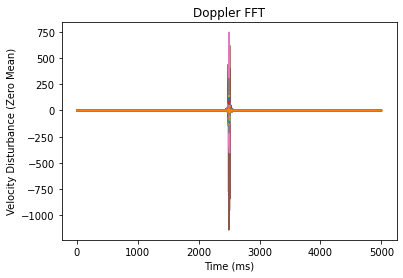

Too Much Movement Detected. Measurement occurs only in Quasistatic State
Vital Readings will be inaccurate


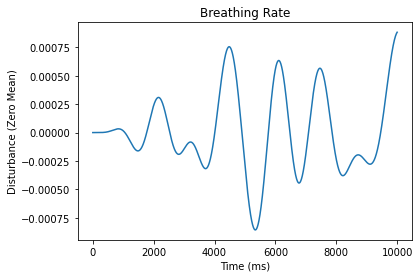

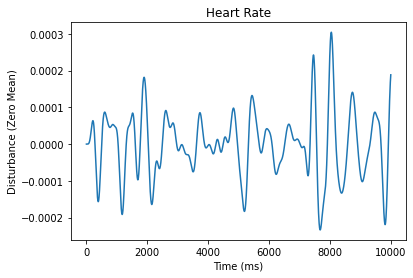

Heart Rate 42
Breath Rate 18
Anxious


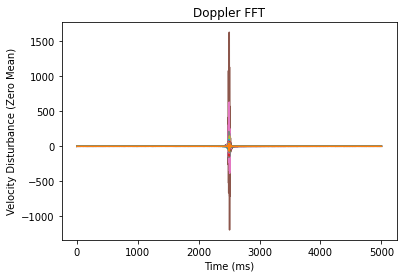

Too Much Movement Detected. Measurement occurs only in Quasistatic State
Vital Readings will be inaccurate


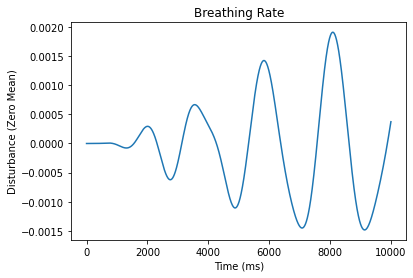

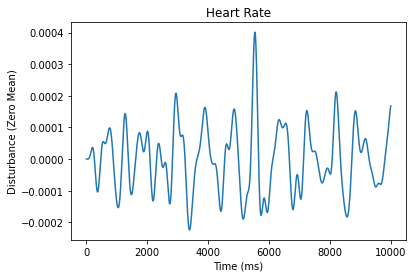

Heart Rate 66
Breath Rate 18
Anxious


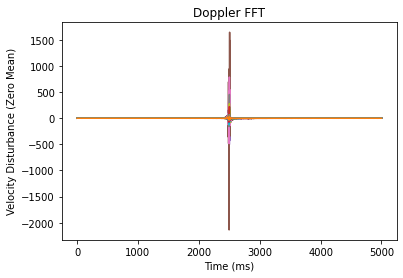

Too Much Movement Detected. Measurement occurs only in Quasistatic State
Vital Readings will be inaccurate


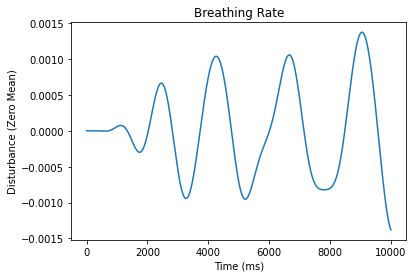

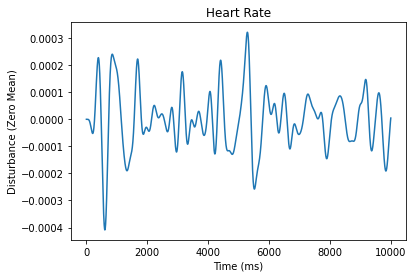

Heart Rate 60
Breath Rate 24
Rest


KeyboardInterrupt: 

In [8]:
"""
Final code block
"""
while True:
    check_movement = motion_detection()
    if check_movement == True:
        print('Too Much Movement Detected. Measurement occurs only in Quasistatic State')
        print('Vital Readings will be inaccurate')
    else:
        print('Quasi-Static State Detected, Proceeding with Measurement')
    
    breathrate, heartrate = get_vitals(phases)
    print('Heart Rate', heartrate)
    print('Breath Rate', breathrate)
    detect_state(phases)